## Time Series - Data Science Portfolio - Maximilian Koch

**Dataset**: Monthly ice cream sales over time<br>
**Target variable**: Predicting ice cream sales over time<br>
**Features**: time index<br>
**Techniques applied**: SARIMA<br>

SARIMA (Seasonal Autoregressive integrated Moving Average) is a model for analysing and forecasting seasonal time series data,
based on regressing the variable onto its lagged values (Autoregression), making the data stationary if needed (integrated),
the dependence on the past forecast errors (Moving Average) and with a seasonal component.

To demonstrate this model I chose a dataset on monthly ice cream sales from 1972 to 2020.
As ice cream sales usually go up during the warmer months, there is a clear seasonality.<br>
Dataset link:
https://www.kaggle.com/datasets/abdocan/monthly-ice-cream-sales-data-1972-2020

In this notebook I will:
* Check stationarity of the time series
* Plot and interpret the auto and partial correlation functions
* Apply automatic (S)ARIMA
* Model and plot the prediction error

### Preprocessing

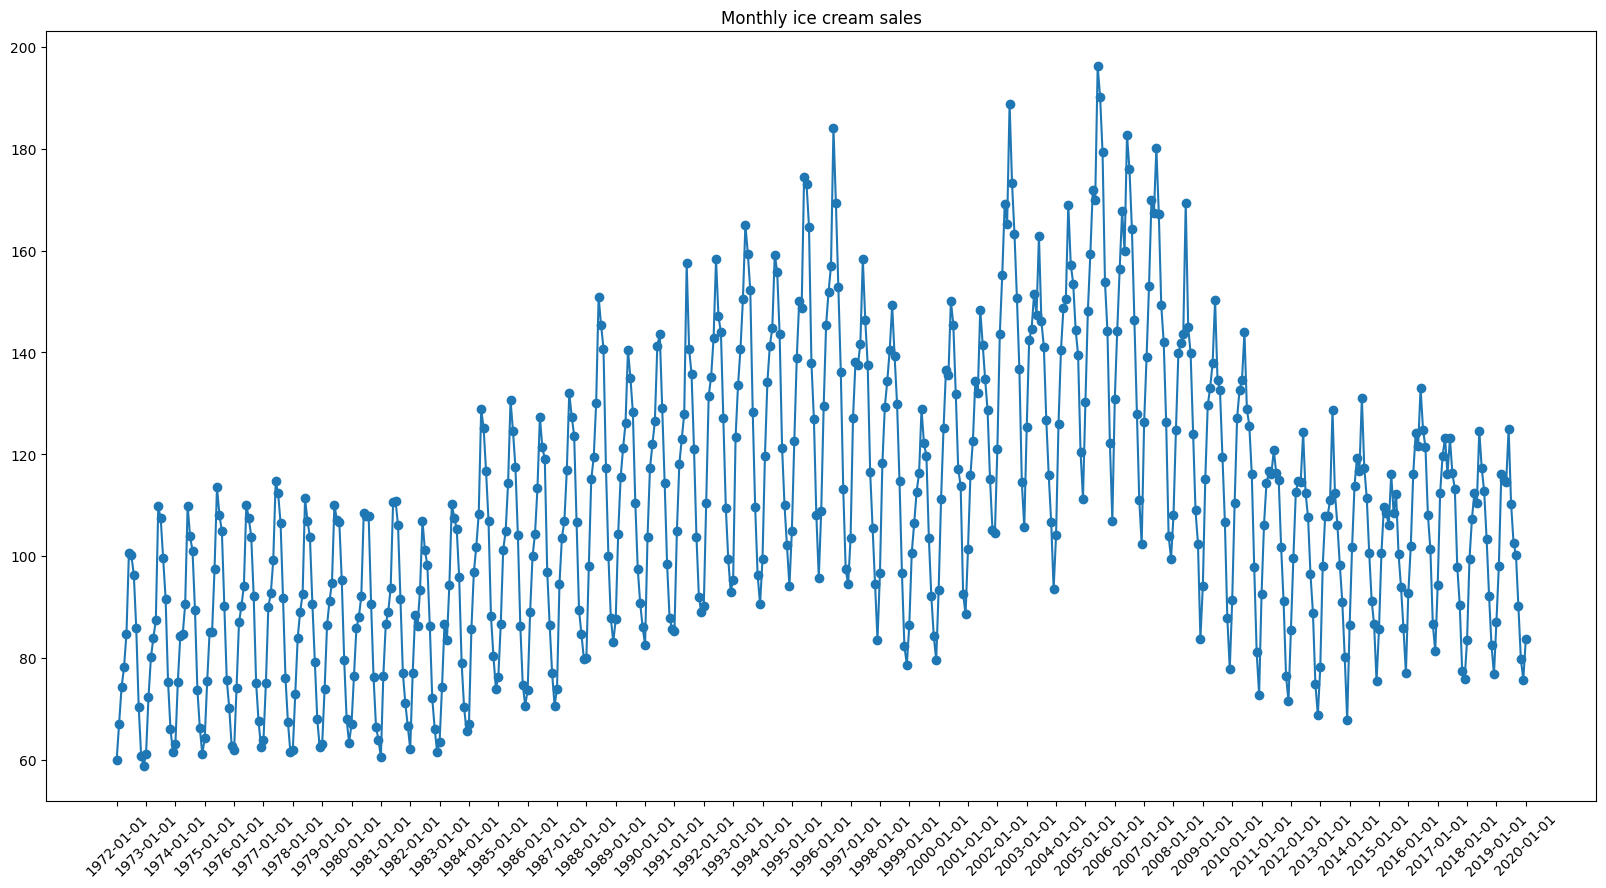

In [2]:
import matplotlib.pyplot as plt
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('datasets/time_series_dataset.csv')
df.columns = ['date','sales']
plt.figure(figsize=(20,10))
plt.plot(df['date'],df['sales'],marker='o')
plt.xticks(df.index[::12],rotation=45)
plt.title('Monthly ice cream sales')
plt.show()

### (Partial) autocorrelation

Checking stationarity:

In [5]:
stationarity = adfuller(df['sales'])[1]
print('ADF p-value:',stationarity)

ADF p-value: 0.40149928994076167


The time series is not stationary. Applying differencing due to the varying variances.
Since there is no strong trend, but clear (yearly) seasonality,
thus applying diff(12)!

In [6]:
df['sales_diff'] = df['sales'].diff(12)

stationarity = adfuller(df['sales_diff'].dropna())[1]
print('ADF p-value:',stationarity)

ADF p-value: 0.0001548877051198262


Now it's stationary!

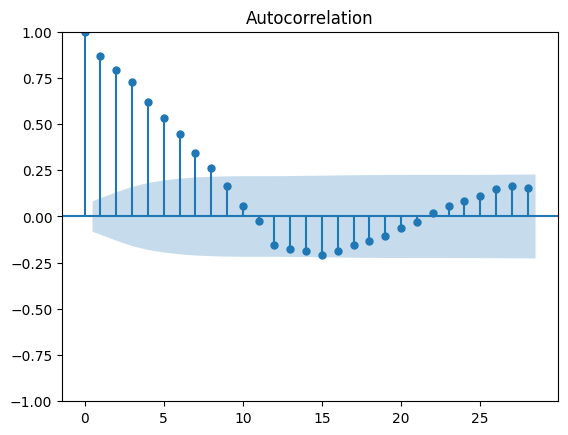

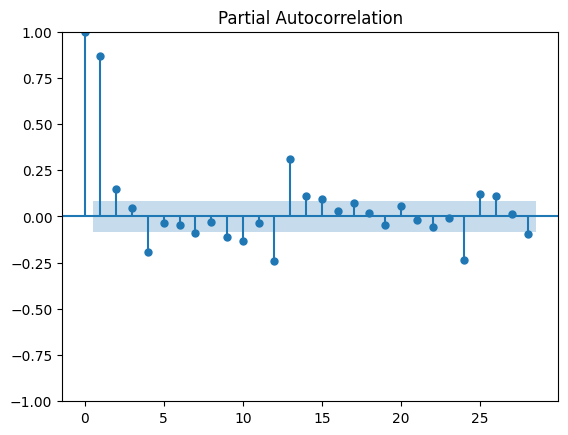

In [7]:
plot_acf(df['sales_diff'].dropna())
plot_pacf(df['sales_diff'].dropna())
plt.show()

The ACF gradually declines, which suggests that there is a significant AR component.
The PACF drops after lag 1, thus p=1.
No differencing for the non-seasonal component was necessary,
thus d=0.
There is no cut-off point for ACF, thus q=0.
There are some drops in the PACF for lag 12 and 24.

### Auto ARIMA

In [8]:
auto_model = auto_arima(df['sales'], m=12, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3276.878, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4490.131, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4025.567, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4488.138, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3466.060, Time=1.75 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3279.172, Time=4.42 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3277.152, Time=3.78 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3905.250, Time=0.83 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=3342.429, Time=4.53 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=3278.979, Time=4.35 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=3305.481, Time=0.97 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept

In [9]:
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  577
Model:             SARIMAX(3, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1627.376
Date:                            Thu, 03 Apr 2025   AIC                           3272.752
Time:                                    11:08:21   BIC                           3311.957
Sample:                                         0   HQIC                          3288.041
                                            - 577                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2677      0.047    -27.151      0.000      -1.359      -1.176
ar.L2         -1.1202      0.052   

All model coefficients are significant except the 24 month seasonal moving average component.

### Prediction error

In [10]:
series = df['sales']
train_size = int(len(series) * 0.8)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

for t in range(len(series_test)):
    model = SARIMAX(history, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    model_fit = model.fit(disp=False) 
    
    #next point forecast and confidence
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)
    predictions.append(yhat[0])
    confidence_intervals.append(conf_int[0])
    
    actual_obs = series_test.iloc[t]
    history = np.append(history, actual_obs)

RMSE: 4.00932040449055


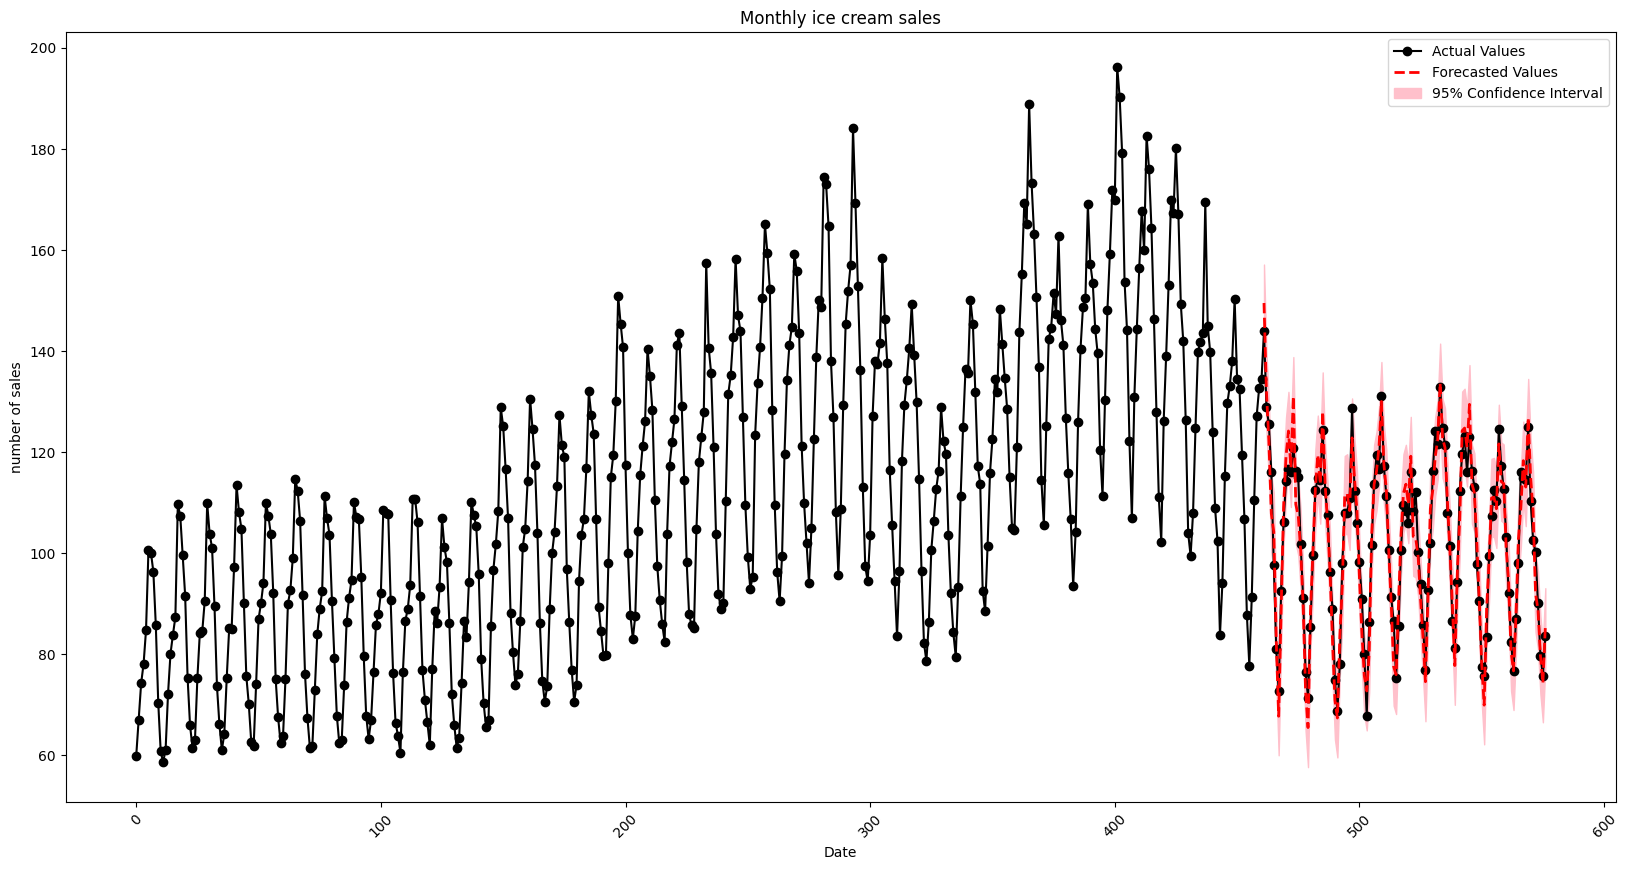

In [12]:
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print('RMSE:',rmse)

#actual and forecasted
plt.figure(figsize=(20,10))
plt.plot(series.index, series, marker='o', color='black', label='Actual Values')
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', label='95% Confidence Interval')

plt.title('Monthly ice cream sales')
plt.xlabel('Date')
plt.ylabel('number of sales')

plt.xticks(rotation=45)
plt.legend()
plt.show()


The fit looks pretty well and the confidence interval of the prediction is also relatively close to the prediction means.